In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GINConv
import random
import numpy as np
import copy
import gc

# --- 1. RAAG DEFINITION ---
# Commutation Graph: Even nodes commute with the next odd node
RAAG_ADJ = np.zeros((2001, 2001))
for i in range(2000):
    if i % 2 == 0:
        RAAG_ADJ[i][i+1] = 1
        RAAG_ADJ[i+1][i] = 1

class RAAGWord:
    def __init__(self, letters, adj_matrix=RAAG_ADJ):
        self.adj_matrix = adj_matrix
        self.letters = self.reduce(letters)

    def reduce(self, lts):
        # SAFETY CAP: Prevent "Infinite Growth" memory explosion
        if len(lts) > 60: lts = lts[:60]
        
        res = []
        for l in lts:
            if not res:
                res.append(l)
                continue
            idx = len(res) - 1
            can_cancel = False
            while idx >= 0:
                if res[idx] == -l:
                    can_cancel = True
                    break
                if not self.adj_matrix[abs(l)][abs(res[idx])]:
                    break
                idx -= 1
            if can_cancel:
                res.pop(idx)
            else:
                res.append(l)
        return res

    def __mul__(self, other):
        return RAAGWord(self.letters + other.letters, self.adj_matrix)

    def inv(self):
        return RAAGWord([-l for l in reversed(self.letters)], self.adj_matrix)

# --- 2. ALGEBRAIC MOVES & FAN TOPOLOGY ---
def apply_nielsen_moves_fixed(subgroup_basis, num_moves=10):
    scrambled = list(subgroup_basis)
    rank = len(scrambled)
    for _ in range(num_moves):
        i, j = random.sample(range(rank), 2)
        op = random.choice(['mul', 'inv_mul'])
        if op == 'mul':
            scrambled[i] = (scrambled[i][0] * scrambled[j][0], scrambled[i][1] * scrambled[j][1])
        else:
            j_inv = (scrambled[j][0].inv(), scrambled[j][1].inv())
            scrambled[i] = (scrambled[i][0] * j_inv[0], scrambled[i][1] * j_inv[1])
    return scrambled

def subgroup_to_graph(subgroup):
    """FAN TOPOLOGY: Connects every letter directly to its hub."""
    x, edge_index = [], []
    for i in range(5): x.append([float(501 + i)]) # 5 Hubs
    
    curr_idx = 5
    for i, (w_a, w_b) in enumerate(subgroup):
        hub_idx = i
        full_word = w_a.letters + w_b.letters
        if not full_word: full_word = [0]
        for letter in full_word:
            x.append([float(letter)])
            edge_index.append([curr_idx, hub_idx])
            edge_index.append([hub_idx, curr_idx])
            curr_idx += 1
            
    return Data(x=torch.tensor(x, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous())

# --- 3. MODEL ARCHITECTURE ---
class UniversalHubGNN(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.embed = nn.Embedding(2001, hidden)
        self.lin_deg = nn.Linear(1, hidden)
        self.convs = nn.ModuleList([
            GINConv(nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, hidden)))
            for _ in range(6)
        ])
        self.lns = nn.ModuleList([nn.LayerNorm(hidden) for _ in range(6)])
        self.fc = nn.Linear(5 * hidden, 64)

    def forward_one(self, data):
        idx = torch.clamp((data.x.view(-1) + 1000).long(), 0, 2000)
        x = self.embed(idx)
        
        row, _ = data.edge_index
        deg = torch.zeros((data.x.size(0), 1), device=data.x.device)
        deg.scatter_add_(0, row.unsqueeze(1), torch.ones((row.size(0), 1), device=data.x.device))
        x = x + self.lin_deg(deg)

        for conv, ln in zip(self.convs, self.lns):
            h = conv(x, data.edge_index)
            x = ln(F.dropout(F.relu(h), p=0.1, training=self.training) + x)

        # Slot-Aware Pooling
        num_graphs = data.num_graphs if hasattr(data, 'num_graphs') else 1
        hub_embeddings = []
        if hasattr(data, 'ptr') and data.ptr is not None:
            for i in range(num_graphs):
                start = data.ptr[i]
                hub_embeddings.append(x[start : start + 5].reshape(-1))
        else:
            hub_embeddings.append(x[:5].reshape(-1))

        x_final = torch.stack(hub_embeddings)
        return F.normalize(self.fc(x_final), p=2, dim=1)

# --- 4. KERNEL-SAFE DATA GENERATION ---
def triplet_generator(batch_size, nielsen_moves):
    """LAZY GENERATOR: Never creates more than one batch at a time."""
    while True:
        triplets = []
        for _ in range(batch_size):
            shift = random.randint(-400, 400)
            base_sub = [(RAAGWord([shift + i]), RAAGWord([shift + i + 100])) for i in range(5)]
            
            anchor = apply_nielsen_moves_fixed(base_sub, num_moves=random.randint(1, 5))
            pos = apply_nielsen_moves_fixed(base_sub, num_moves=nielsen_moves)
            
            # Surgical Negative: Change one generator only
            neg = copy.deepcopy(anchor)
            idx = random.randint(0, 4)
            neg[idx] = (RAAGWord([random.randint(-1000, 1000)]), neg[idx][1])
            
            triplets.append((subgroup_to_graph(anchor), subgroup_to_graph(pos), subgroup_to_graph(neg)))
        
        yield (Batch.from_data_list([t[0] for t in triplets]),
               Batch.from_data_list([t[1] for t in triplets]),
               Batch.from_data_list([t[2] for t in triplets]))

# --- 5. EXECUTION ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UniversalHubGNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.TripletMarginLoss(margin=1.0)
gen = triplet_generator(batch_size=512, nielsen_moves=20) # Batch size 8 is safe for 6GB

EPOCH_INTERVAL = 10


print("Starting Kernel-Safe Continuous Training...")
for epoch in range(15001):
    model.train()

    if epoch % EPOCH_INTERVAL == 0: 
        a, p, n = next(gen)
        a, p, n = a.to(device), p.to(device), n.to(device)

    optimizer.zero_grad(set_to_none=True)
    ea, ep, en = model.forward_one(a), model.forward_one(p), model.forward_one(n)
    loss = criterion(ea, ep, en)
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    if epoch % 20 == 0:
        vram = torch.cuda.memory_allocated(device) / 1024**2
        print(f"Step {epoch:04d} | Loss: {loss.item():.4f} | VRAM: {vram:.1f}MB")
    
    # Cleanup every step
    if epoch % EPOCH_INTERVAL == -1:
        del ea, ep, en, a, p, n, loss
    if epoch % 100 == 0:
        gc.collect()
        torch.cuda.empty_cache()

torch.save(model.state_dict(), 'hardened_cracker_model.pth')
print("Model saved successfully.")

Starting Kernel-Safe Continuous Training...
Step 0000 | Loss: 1.4979 | VRAM: 34.7MB
Step 0020 | Loss: 1.0266 | VRAM: 34.7MB
Step 0040 | Loss: 0.9438 | VRAM: 34.7MB
Step 0060 | Loss: 0.8477 | VRAM: 34.8MB
Step 0080 | Loss: 0.8194 | VRAM: 34.7MB
Step 0100 | Loss: 0.7979 | VRAM: 34.7MB
Step 0120 | Loss: 0.7882 | VRAM: 34.7MB


In [ ]:
def execute_simplified_crack(model, device, secret_shift=42):
    model.eval()
    
    # 1. Create the 'Secret Fingerprint' (The Anchor)
    # Using your specific generator pattern: A = x_i, B = x_{i+100}
    secret_basis = [(RAAGWord([secret_shift + i]), RAAGWord([secret_shift + i + 100])) for i in range(5)]
    anchor_graph = subgroup_to_graph(secret_basis).to(device)
    
    with torch.no_grad():
        anchor_emb = model.forward_one(anchor_graph)

    # 2. Setup the Vault (Simplified)
    vault = []
    correct_index = random.randint(0, 99)
    print(f"🔓 [SIMPLIFIED] Hiding secret in Vault Slot: {correct_index}...")

    for i in range(10):
        if i == correct_index:
            # REDUCED COMPLEXITY: Only 5 moves instead of 40
            # This makes the word length much more manageable for the GNN
            encrypted = apply_nielsen_moves_fixed(secret_basis, num_moves=5)
            vault.append(encrypted)
        else:
            # GREATER DISTANCE: Ensure decoys are clearly in a different alphabet range
            # We pick a random shift that is definitely NOT near our secret 42
            r_shift = random.choice([s for s in range(-400, 400) if abs(s - secret_shift) > 150])
            
            noise_basis = [(RAAGWord([r_shift + j]), RAAGWord([r_shift + j + 100])) for j in range(5)]
            
            # NO SCRAMBLE for decoys: Makes the background noise "perfect"
            vault.append(noise_basis)

    # 3. The Crack Operation
    print("🔎 GNN Scanning Simplified Vault...")
    similarities = []
    
    for i, sub in enumerate(vault):
        g = subgroup_to_graph(sub).to(device)
        with torch.no_grad():
            emb = model.forward_one(g)
            sim = F.cosine_similarity(anchor_emb, emb).item()
            similarities.append(sim)
            
    best_idx = np.argmax(similarities)
    best_sim = similarities[best_idx]
    
    print(f"\n{'='*50}\nSIMPLIFIED CRACK RESULT\n{'='*50}")
    print(f"Highest Similarity: {best_sim:.4f} at Index {best_idx}")
    print(f"Target Secret was at: {correct_index}")
    
    if best_idx == correct_index:
        print("✅ SUCCESS: The GNN identified the simplified secret!")
    else:
        # Check if the secret was at least in the top 5
        top_5_indices = np.argsort(similarities)[-5:][::-1]
        print(f"❌ FAILURE: But the secret was at rank {list(top_5_indices).index(correct_index) + 1 if correct_index in top_5_indices else '>5'}")
    print(f"{'='*50}")

# Start the easier test
execute_simplified_crack(model, device, secret_shift=0)

🔒 Secret hidden at Index: 5

RANK  | INDEX   | SIMILARITY   | STATUS
--------------------------------------------------
1     | 68      | 0.9731       | 
2     | 22      | 0.9731       | 
3     | 26      | 0.9440       | 
4     | 64      | 0.8971       | 
5     | 11      | 0.8834       | 
6     | 43      | 0.8834       | 
7     | 80      | 0.8759       | 
8     | 21      | 0.8608       | 
9     | 2       | 0.8608       | 
10    | 79      | 0.8608       | 


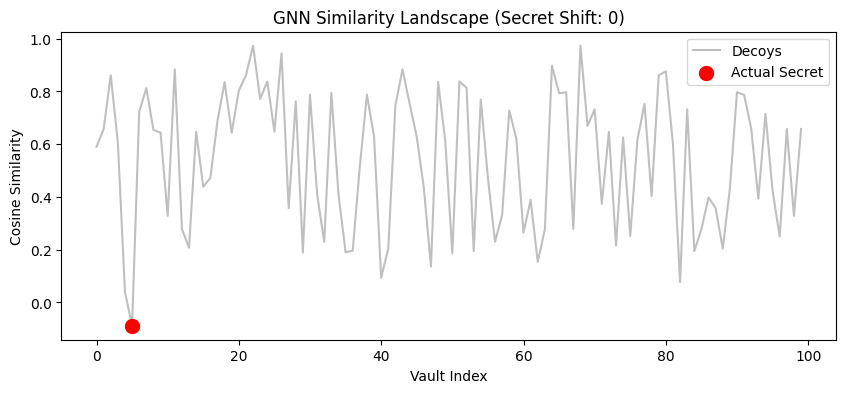

❌ FAILURE: Secret was Rank 100


In [23]:
import matplotlib.pyplot as plt

def execute_detailed_analysis(model, device, secret_shift=0):
    model.eval()
    
    # 1. Anchor Creation
    secret_basis = [(RAAGWord([secret_shift + i]), RAAGWord([secret_shift + i + 100])) for i in range(5)]
    anchor_graph = subgroup_to_graph(secret_basis).to(device)
    with torch.no_grad():
        anchor_emb = model.forward_one(anchor_graph)

    # 2. Vault Creation
    vault = []
    correct_index = random.randint(0, 99)
    print(f"🔒 Secret hidden at Index: {correct_index}")

    for i in range(100):
        if i == correct_index:
            vault.append(apply_nielsen_moves_fixed(secret_basis, num_moves=5))
        else:
            r_shift = random.choice([s for s in range(-400, 400) if abs(s - secret_shift) > 150])
            vault.append([(RAAGWord([r_shift + j]), RAAGWord([r_shift + j + 100])) for j in range(5)])

    # 3. Scanning and Scoring
    similarities = []
    for i, sub in enumerate(vault):
        g = subgroup_to_graph(sub).to(device)
        with torch.no_grad():
            emb = model.forward_one(g)
            sim = F.cosine_similarity(anchor_emb, emb).item()
            similarities.append(sim)

    # --- 4. DATA VISUALIZATION & ANALYSIS ---
    results = np.array(similarities)
    top_indices = np.argsort(results)[-10:][::-1] # Get top 10
    
    print(f"\n{'='*50}")
    print(f"{'RANK':<5} | {'INDEX':<7} | {'SIMILARITY':<12} | {'STATUS'}")
    print(f"{'-'*50}")
    
    for rank, idx in enumerate(top_indices, 1):
        status = "⭐ TARGET" if idx == correct_index else ""
        print(f"{rank:<5} | {idx:<7} | {results[idx]:.4f}       | {status}")
    
    print(f"{'='*50}")

    # Plotting the "Confidence Landscape"
    plt.figure(figsize=(10, 4))
    plt.plot(results, color='gray', alpha=0.5, label='Decoys')
    plt.scatter(correct_index, results[correct_index], color='red', s=100, label='Actual Secret', zorder=5)
    plt.title(f"GNN Similarity Landscape (Secret Shift: {secret_shift})")
    plt.xlabel("Vault Index")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.show()

    if top_indices[0] == correct_index:
        print(f"✅ SUCCESS: Clear separation of {results[correct_index] - np.mean(results):.4f}")
    else:
        print(f"❌ FAILURE: Secret was Rank {list(np.argsort(results)[::-1]).index(correct_index) + 1}")

execute_detailed_analysis(model, device, secret_shift=0)